In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
#from MaaSSim.acceptance import results
#from MaaSSim.acceptance import f_decline

In [4]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [5]:
# Do not forget to set the radius for centeral nodes calculation
# The minimum trip distance is considered 1000m and this can be modified through utils.py: generate_demand function. 
# long attribute should be calculated according to the size of city

params = MaaSSim.utils.get_config('glance.json')
params.use_fixed_postions = True
params.times.patience = 600 #in second
params.dist_threshold = 10000 #in meter
params.vehicle_fixed_positions= True  #this should be fixed
params.city = "Delft, Netherland"
params.paths.G = "../../data/graphs/Delft.graphml"
params.paths.skim = "../../data/graphs/Delft.csv"
params.nP = 10
params.nV = 3
params.simTime =5

In [6]:
sim= MaaSSim.simulators.simulate(params=params)

position of vehicle 1 is 44847014
04-11-21 14:59:13-WARNING-Setting up 5h simulation at 2021-11-04 12:37:04 for 3 vehicles and 10 passengers in Delft, Netherland
position of vehicle 1 is 44847014
04-11-21 14:59:13-INFO--------------------	Starting simulation	-------------------
04-11-21 14:59:13-INFO-pax    0  got to dest at                           2021-11-04 12:45:12
04-11-21 14:59:13-INFO-pax    1  got to dest at                           2021-11-04 12:58:58
04-11-21 14:59:13-INFO-pax    2  got to dest at                           2021-11-04 14:19:37
04-11-21 14:59:13-INFO-pax    3  got to dest at                           2021-11-04 14:54:16
04-11-21 14:59:13-INFO-pax    4  got to dest at                           2021-11-04 15:59:56
04-11-21 14:59:13-INFO-pax    5  got to dest at                           2021-11-04 16:44:13
04-11-21 14:59:13-INFO-pax    6  got to dest at                           2021-11-04 17:00:20
04-11-21 14:59:13-INFO-pax    7  got to dest at                

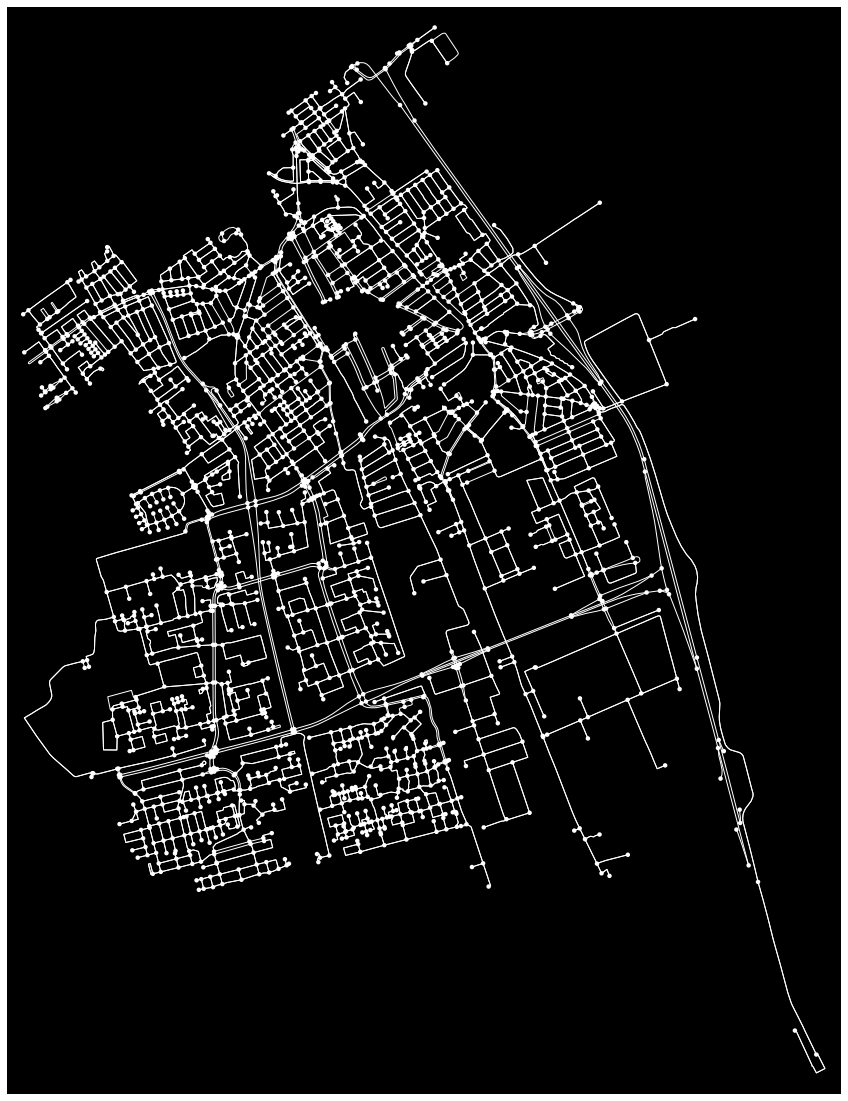

In [7]:
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(20, 20), show=False, close=False, node_size=20, bgcolor='black', edge_color='w')

In [14]:
# 50% & 50% Primary BIP implemented on First regime 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


def f_decline(veh, **kwargs):
    
    if veh.id > sim.params.nV/2:
        return False
    else:
        df = pd.DataFrame(veh.myrides)
        ASC = 1.5                                                                                   #ASC
    
        working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0

        if veh.veh['pos'] in sim.inData.stats.central_nodes:
            loc = 1
        else:
            loc = 0
        
        
        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 
    
        surge_price = 0                                                                               #surge_price
    
        req = 1                         #req                                                          #req_long_rate_dec
    
        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0
        
        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
        if last_declined == 'True':
            dec = 1
        else:
            dec = 0
        
    
           
        V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
            ((req*long*rate*dec)*0.0909) + (surge_price*0.099))
    
    
        acc_prob = (math.exp(V))/(1+math.exp(V))
    

    
        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

position of vehicle 1 is 44791815
04-11-21 15:17:13-INFO--------------------	Starting simulation	-------------------
04-11-21 15:17:13-INFO-pax    0  got to dest at                           2021-11-04 13:00:34
04-11-21 15:17:13-WARNING-pax    1  got rejected by vehicle 1                2021-11-04 13:19:56
04-11-21 15:17:13-INFO-pax    1  got to dest at                           2021-11-04 13:31:37
04-11-21 15:17:13-INFO-pax    2  got to dest at                           2021-11-04 13:45:44
04-11-21 15:17:13-INFO-pax    3  got to dest at                           2021-11-04 14:26:00
04-11-21 15:17:13-INFO-pax    4  got to dest at                           2021-11-04 15:11:36
04-11-21 15:17:13-INFO-pax    5  got to dest at                           2021-11-04 15:19:43
04-11-21 15:17:13-INFO-pax    7  got to dest at                           2021-11-04 15:31:46
04-11-21 15:17:13-INFO-pax    6  got to dest at                           2021-11-04 15:35:06
04-11-21 15:17:13-WARNING-pax    8

In [ ]:
r_5050= results(sim)

In [20]:
#random utilities for heterogeneous model

mu, theta = 0, 1 # location and scale
ranres = np.random.gumbel(mu, theta, params.nV)
ranres

array([5.19231239, 0.65071097, 2.9484975 ])

In [23]:
# Heterogenous Primary BIP implemented on First regime 

import pandas as pd
import math
import random as random
from dotmap import DotMap


def f_decline(veh, **kwargs):
    
    df = pd.DataFrame(veh.myrides)
    ASC = 1.5                                                                                   #ASC
    
    working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
    T1 = int(working_shift/3)
    request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']
    
    if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
        Time1 = 1
    else:
        Time1 = 0
        
    if veh.veh['pos'] in sim.inData.stats.central_nodes:
        loc = 1
    else:
        loc = 0
        
        
    d = veh.offers[0]['request']["origin"]                                                       #pickup_time
    o = veh.veh.pos
    pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
    t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
    if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
        t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
    else:
        t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
    waiting_time = (t - t0)/60 #minutes 
    
    surge_price = 0                                                                               #surge_price
    
    req = 1                         #req                                                          #req_long_rate_dec
    
    if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
        long = 1
    else:
        long = 0
        
    rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
    if len(veh.declines.index) == 0:          #dec
        last_declined = 'False'
    else:
        last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
    if last_declined == 'True':
        dec = 1
    else:
        dec = 0
        
    
           
    #V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
     #   ((req*long*rate*dec)*0.0909) + (surge_price*0.099))

    eps = ranres[veh.id-1]
    V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
        ((req*long*rate*dec)*0.0909) + (surge_price*0.099)) + eps    
    
    acc_prob = (math.exp(V))/(1+math.exp(V))
    
#     print('----------------------------------------------------------------------------')
#     print('vehicle id is ', veh.id)
#     print('acceptance probability is ', acc_prob)
#     print('ASC*1 is ', ASC*1)
#     print('Time1*loc*(-0.263) is ',Time1*loc*(-0.263))
#     print('pickup_time*(-0.0491) is ',pickup_time*(-0.0491))   
#     print('waiting_time*(-0.0173) is ',waiting_time*(-0.0173))
#     print('(req*long*rate*dec)*0.0909 is ',(req*long*rate*dec)*0.0909)
#     print('surge_price*0.099 is ',surge_price*0.099)
#     #print('Random residual is ', eps)
#     print('Systematic Utility V is ', V)
#     print('----------------------------------------------------------------------------')
    
    if acc_prob > 0.5:
    #if acc_prob > random.uniform(0, 1):
        return False
    else:
        return True

sim.make_and_run(f_driver_decline=f_decline)

position of vehicle 1 is 44791815
04-11-21 15:19:36-INFO--------------------	Starting simulation	-------------------
04-11-21 15:19:36-INFO-pax    0  got to dest at                           2021-11-04 13:00:34
04-11-21 15:19:36-INFO-pax    1  got to dest at                           2021-11-04 13:27:24
04-11-21 15:19:36-INFO-pax    2  got to dest at                           2021-11-04 13:45:44
04-11-21 15:19:36-INFO-pax    3  got to dest at                           2021-11-04 14:26:00
04-11-21 15:19:36-INFO-pax    4  got to dest at                           2021-11-04 15:11:36
04-11-21 15:19:36-INFO-pax    5  got to dest at                           2021-11-04 15:19:43
04-11-21 15:19:36-INFO-pax    7  got to dest at                           2021-11-04 15:31:46
04-11-21 15:19:36-INFO-pax    6  got to dest at                           2021-11-04 15:35:06
04-11-21 15:19:36-INFO-pax    8  got to dest at                           2021-11-04 17:09:52
04-11-21 15:19:36-INFO-pax    9  got 

In [9]:
# 50% & 50% Primary BIP implemented on First regime 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap

sim.acceptance_attributes = pd.DataFrame()

def f_decline(veh, **kwargs):
    
    if veh.id > (sim.params.nV/2):
    #if veh.id < (sim.params.nV/2)+1:
        if random.uniform(0, 1) > ave_p:
            return True
        else:
            return False
    else:
        df = pd.DataFrame(veh.myrides)
        ASC = 1.810                                                                                   #ASC
    
        working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0

        if veh.veh['pos'] in sim.inData.stats.central_nodes:
            loc = 1
        else:
            loc = 0
        
        
        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 
    
        surge_price = 0                                                                               #surge_price
    
        req = 1                         #req                                                          #req_long_rate_dec
    
        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0
        
        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
        if last_declined == 'True':
            dec = 1
        else:
            dec = 0
        
           
        V = ((ASC*1) + (Time1*loc*(-0.303)) + (pickup_time*(-0.050)) + (waiting_time*(-0.017)) + 
            ((req*long*rate*dec)*0.091) + (surge_price*0.101))
    
    
        acc_prob = (math.exp(V))/(1+math.exp(V))

        attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 
                             'Time1_loc':[Time1*loc*(-0.303)], 'pickup_time':[pickup_time*(-0.050)],
                             'waiting_t':[waiting_time], 'surge_price':[surge_price*0.101], 
                             'req_long_rate_dec':[req*long*rate*dec*0.091], 'P':[acc_prob]})
        sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

18-11-21 12:31:36-WARNING-pax    4  got rejected by vehicle 16               2021-11-18 10:02:52
18-11-21 12:31:36-WARNING-pax   11  got rejected by vehicle 16               2021-11-18 10:06:27
18-11-21 12:31:36-WARNING-pax   12  got rejected by vehicle 14               2021-11-18 10:07:03
18-11-21 12:31:36-WARNING-pax   12  got rejected by vehicle 17               2021-11-18 10:07:03
18-11-21 12:31:36-WARNING-pax   13  got rejected by vehicle 17               2021-11-18 10:07:21
18-11-21 12:31:36-WARNING-pax   15  got rejected by vehicle 18               2021-11-18 10:08:56
18-11-21 12:31:36-WARNING-pax   18  got rejected by vehicle 16               2021-11-18 10:11:43
18-11-21 12:31:36-WARNING-pax   24  got rejected by vehicle 13               2021-11-18 10:15:19
18-11-21 12:31:36-WARNING-pax   29  got rejected by vehicle 19               2021-11-18 10:16:15
18-11-21 12:31:36-WARNING-pax   30  got rejected by vehicle 18               2021-11-18 10:17:05
18-11-21 12:31:36-WARNING-pax 

In [10]:
first_half = r_5050.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV/2)].sum()
second_half = r_5050.trips.groupby(['veh_id']).sum().iloc[int(params.nV/2):int(params.nV)].sum()

print('The sum for drivers employing acceptance function is ', first_half )
print('---------------------------------------------------------')
print('---------------------------------------------------------')
print('The sum for drivers accepting all requests is ', second_half)

The sum for drivers employing acceptance function is  pax_id                60391.000000
pickup_t[min]           697.766667
pickup_d[km]            418.660000
travel_t_with[min]     1331.100000
pax_km                  798.660000
travel_t[min]          2155.650000
travel_d[km]           1293.390000
veh_waiting_t[sec]    47135.000000
revenue $              1597.320000
dtype: float64
---------------------------------------------------------
---------------------------------------------------------
The sum for drivers accepting all requests is  pax_id                63495.000000
pickup_t[min]           694.950000
pickup_d[km]            416.970000
travel_t_with[min]     1140.933333
pax_km                  684.560000
travel_t[min]          1959.950000
travel_d[km]           1175.970000
veh_waiting_t[sec]    57510.000000
revenue $              1369.120000
dtype: float64


In [54]:
# 50% & 50% 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


dist_lim = sim.requests['dist'].quantile(0.5)

def f_decline(veh, **kwargs):
    
    if veh.id > sim.params.nV/2:
        return False
    else:
        df = pd.DataFrame(veh.myrides)
    
        travel_dist = veh.offers[0]["request"]["dist"]
           

        if travel_dist > dist_lim:
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

11-11-21 11:02:53-INFO--------------------	Starting simulation	-------------------
11-11-21 11:02:53-WARNING-pax    1  got rejected by vehicle 15               2021-11-11 10:32:29
11-11-21 11:02:53-WARNING-pax    1  got rejected by vehicle 16               2021-11-11 10:32:29
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 15               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 19               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 16               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 18               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 14               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 12               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    5  got rejected by vehicle 10               2021-11-11 10:32:45
11-11-21 11:02:53-WARNING-pax    5  got reje

In [ ]:
first_half = r_5050.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV/2)].sum()
second_half = r_5050.trips.groupby(['veh_id']).sum().iloc[int(params.nV/2):int(params.nV)].sum()

print('The sum for drivers employing acceptance function is ', first_half )
print('---------------------------------------------------------')
print('---------------------------------------------------------')
print('The sum for drivers accepting all requests is ', second_half)

In [ ]:
1- fix the position for the vehicles "solved"
2- solve the error with acceptance function (<Event() object at 0x7fa188eca460> has already been triggered) "solved"
3- passengers can not wait for ever! set a limit "solved"